<a href="https://colab.research.google.com/github/willewiik/Time-Series-and-Sequence-Learning/blob/main/old_exams/exam_22_02_16_TS/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/willewiik/Time-Series-and-Sequence-Learning.git
%cd "Time-Series-and-Sequence-Learning/old_exams/exam_22_02_16_TS"

Cloning into 'Time-Series-and-Sequence-Learning'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 74 (delta 28), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 1.20 MiB | 8.61 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/Time-Series-and-Sequence-Learning/old_exams/exam_22_02_16_TS


# Problem 3

(11p)

**a)** Consider the following model
$$
    \begin{cases} \alpha_{t+1} = \phi \cdot \alpha_t + \eta_t,& \eta_t \sim \mathcal{N}(0,\sigma^2), \\
    y_t = \beta \exp(\alpha_t/2) \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0, 1), \end{cases}
$$
with $\alpha_1 = 0$.

Since this is a non-Linear model a particle filter can be used to estimate the hidden states $\alpha_t$ conditioned on the observations $y_t$. For these algorithms we need to define the distributions of **propoagation** ($p(\alpha_{t+1} | \alpha_t$)) and **observation** ($p(y_t | \alpha_t$).

Write out these **two** distrubtions and implement the two functions:
- `propagate` that simulates $N$ particles of $\alpha_{t+1}$ conditioned on a set of $N$ particles approximating $\alpha_t$.
- `logwgtfun` that calculates the log of the observation density given $N$ particles.

<div style="text-align: right"> (3p) </div>

**Solution:**

In [52]:

from scipy.stats import norm
def propagate(particles, phi, sigma):
  new_part = phi * particles + np.random.normal(0, sigma, len(particles))
  return new_part

def logwgtfun(particles, y, beta):
  sigma = 1
  mean = np.log(beta) + particles/2
  log_density = norm.logpdf(y, mean, scale = sigma)
  return log_density

---

**b)** This model if often used to model log-return of financial instruments, to do prediction and procing of these instruments we need to calculate the hidden states $\alpha_t$ conditioned on the observations $y_t$.

Using the values $\phi = 0.9$, $\sigma = 0.16$, and $\beta = 0.7$ implement and run the bootstrap particle filter on the data provided in `data_problem3.csv`.

Provide a plot of $\mathbb{E}[\alpha_t \mid y_t]$ and a plot of $\mathbb{P}(\alpha_t > 0 | y_t)$ for $t = 1, 2, 3, \ldots$. Use at least $N = 200$ particles in your estimates.

_hint: if you did not solve **a)** you can use `propagate_wrong` and `logwgtfun_wrong` from `tssltools.py`, note that these are not the correct functions and you should use your functions from **a)** if you have any._

<div style="text-align: right"> (5p) </div>

**Solution:**

In [56]:
from tssltools import exp_norm, smc_res, logwgtfun_wrong

def ESS(wgt):
  ess = np.sum(wgt)**2 / (np.sum(wgt**2))
  return ess

def bpf(y, numParticles, phi, sigma , beta):
  N = numParticles
  n = len(y)
  particles = np.zeros((N,n),dtype = float)
  logW = np.zeros((N,n))
  W = np.zeros((N,n))
  alpha_filt = np.zeros(n)
  N_eff = np.zeros(n)
  logZ = 0
  for t in range(n):
    if t == 0:
      particles[:,0] = np.zeros(N)
    else:
      ind = np.random.choice(N,N, replace = True, p = W[:, t-1])
      resampled_particles = particles[ind,t-1]
      particles[:,t] = propagate(resampled_particles, phi, sigma)

    logW[:,t] = logwgtfun(particles[:,t], y[t], beta)
    W[:,t], log_Z_now = exp_norm(logW[:,t])
    logZ += log_Z_now - np.log(N)
    N_eff[t] = ESS(W[:,t])
    alpha_filt[t] = np.sum(particles[:,t] * W[:,t])

  return smc_res(alpha_filt, particles, W, N_eff = N_eff, logZ = logZ)



500


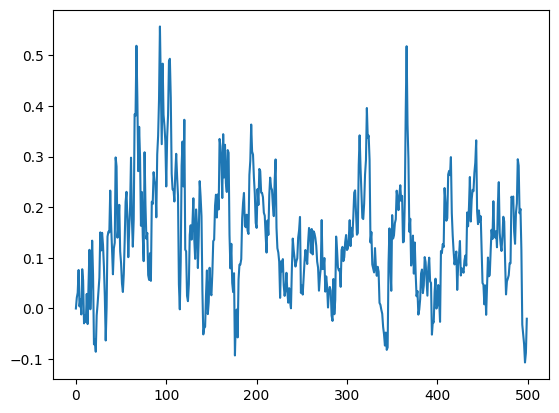

In [57]:
data = pd.read_csv('data_problem3.csv',header=None)
y = data
print(len(y))
bpf_result = bpf(y = np.array(y), numParticles = 200, phi =0.9, sigma = 0.16 , beta = 0.7)
plt.plot(bpf_result.alpha_filt)

200


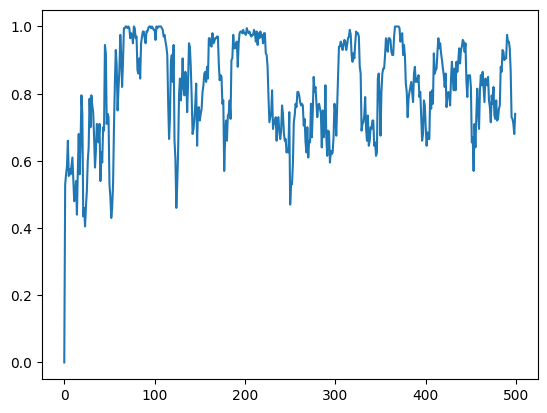

In [61]:
proportions = np.sum(bpf_result.particles > 0, axis = 0)/ bpf_result.particles.shape[0]
plt.plot(proportions)
print(bpf_result.particles.shape[0])

------

**c)** For these models one or more of the parameters may be unknown. We wish to find the best estimate for the parameter $\phi$ we know from previous studies that the correct value of between 0.8 and 1. Use a bootstrap particle filter to find best estimate by taking a grid of different $\phi$ values and calculating the log-likelihood for these values.

Present a plot of your log-likelihood estimates and the numerical value that you choose for $\phi$.

<div style="text-align: right"> (3p) </div>

**Solution:**

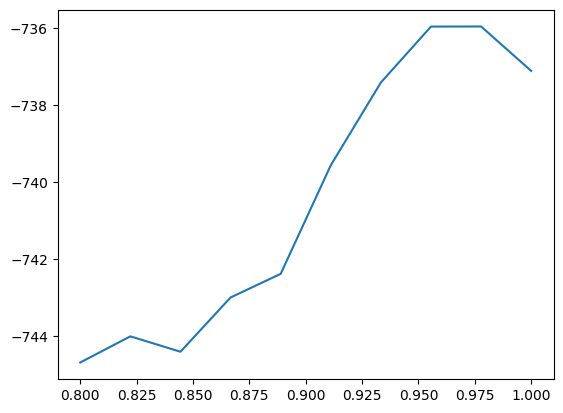

In [60]:
log_like = []

for i in np.linspace(0.8,1,10):
  bpf_result = bpf(y = np.array(y), numParticles = 200, phi =i, sigma = 0.16 , beta = 0.7)
  log_like.append(bpf_result.logZ)

plt.plot(np.linspace(0.8,1,10),log_like)